# Understanding YOLO Output

## Yolo output have 3 scale and each scale have 3 anchor
(x,y, (anchor*5+class) )
(x,y,anchor,5+class) 5 - > consist of (x,y,w,h,conf)

In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import numpy as np
import keras.backend as K
import h5py
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, Lambda ,Reshape
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import TensorBoard, ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

from model.core import yolo_head,preprocess_true_boxes, yolo_loss
from model.yolo3 import yolo_body, tiny_yolo_body
from model.utils import get_random_data

from tqdm import tqdm
import time

Using TensorFlow backend.


In [2]:

def get_classes(classes_path):
    '''loads the classes'''
    with open(classes_path) as f:
        class_names = f.readlines()
    class_names = [c.strip() for c in class_names]
    return class_names

def get_anchors(anchors_path):
    '''loads the anchors from a file'''
    with open(anchors_path) as f:
        anchors = f.readline()
    anchors = [float(x) for x in anchors.split(',')]
    return np.array(anchors).reshape(-1, 2)

In [3]:
def data_generator(annotation_lines, batch_size, input_shape, anchors, num_classes,model,new_model):
    '''data generator for fit_generator'''

    n = len(annotation_lines)
    i = 0
    while True:
        image_data = []
        box_data = []
        for b in range(batch_size):
            #if i==0:
            #    print("random")
            #    np.random.shuffle(annotation_lines)
            print(annotation_lines[i])
            image, box = get_random_data(annotation_lines[i], input_shape, random=False)
            image_data.append(image)
            box_data.append(box)
            i = (i+1) % n
        image_data = np.array(image_data)
        box_data = np.array(box_data)
        y_true = preprocess_true_boxes(box_data, input_shape, anchors, num_classes)
       # print(image_data.shape)
        m_true = new_model.predict(image_data)
        om_true = model.predict(image_data) 

        yield image_data , box_data , y_true , m_true , om_true #, np.zeros(batch_size)

def data_generator_wrapper(annotation_lines, batch_size, input_shape, anchors, num_classes,model,new_model):
    n = len(annotation_lines)
    if n==0 or batch_size<=0: return None
    return data_generator(annotation_lines, batch_size, input_shape, anchors, num_classes,model,new_model)

In [4]:
train_path = '2007_train.txt'
val_path = '2007_val.txt'
# test_path = '2007_test.txt'
log_dir = 'logs/000/'
classes_path = 'class/voc_classes.txt'
anchors_path = 'anchors/yolo_anchors.txt'
class_names = get_classes(classes_path)
num_classes = len(class_names)
anchors = get_anchors(anchors_path)
num_anchors = len(anchors)

input_shape = (416,416) # multiple of 32, hw

with open(train_path) as f:
    train_lines = f.readlines()

with open(val_path) as f:
    val_lines = f.readlines()

# with open(test_path) as f:
#     test_lines = f.readlines()

num_anchors = len(anchors)
image_input = Input(shape=(416, 416, 3))
model = yolo_body(image_input, num_anchors//3, num_classes)
model.load_weights("model_data/trained_weights_final.h5")

yolo3 = Reshape((13, 13, 3, 25))(model.layers[-3].output)
yolo2 = Reshape((26, 26, 3, 25))(model.layers[-2].output)
yolo1 = Reshape((52, 52, 3, 25))(model.layers[-1].output)


new_model = Model( inputs= model.input , outputs=[yolo3,yolo2,yolo1] )

batch_size = 1

#train_lines

In [5]:
obj = ["aeroplane", "bicycle", "bird", "boat", "bottle", "bus", "car", "cat", "chair", "cow", "diningtable", "dog", "horse", "motorbike", "person", "pottedplant", "sheep", "sofa", "train", "tvmonitor"]

batch_size = 1

image = {}
box = {}
train_logits = {}
model_logits = {}

datagen = data_generator_wrapper(train_lines, batch_size, input_shape, anchors, num_classes,model,new_model)

D:\python\YOLO-Collection\yolov3-keras/VOCdevkit/VOC2007/JPEGImages/000012.jpg 156,97,351,270,6



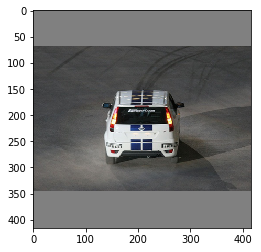

In [6]:
img,box_data,flogits,mlogits,omlogits = next(datagen)

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

plt.imshow(img[0])
plt.show()

In [7]:
flogits[0].shape

(1, 13, 13, 3, 25)

In [8]:
np.set_printoptions(threshold=np.inf)

In [67]:
def yolo_head(feats, anchors, num_classes, input_shape, calc_loss=False):
    """Convert final layer features to bounding box parameters."""
    num_anchors = len(anchors)
    # Reshape to batch, height, width, num_anchors, box_params.
    anchors_tensor = K.reshape(K.constant(anchors), [1, 1, 1, num_anchors, 2])

    grid_shape = K.shape(feats)[1:3] # height, width
    grid_y = K.tile(K.reshape(K.arange(0, stop=grid_shape[0]), [-1, 1, 1, 1]),
        [1, grid_shape[1], 1, 1])
    grid_x = K.tile(K.reshape(K.arange(0, stop=grid_shape[1]), [1, -1, 1, 1]),
        [grid_shape[0], 1, 1, 1])
    grid = K.concatenate([grid_x, grid_y])
    grid = K.cast(grid, K.dtype(feats))

    feats = K.reshape(
        feats, [-1, grid_shape[0], grid_shape[1], num_anchors, num_classes + 5])

    # Adjust preditions to each spatial grid point and anchor size.
    box_xy = (K.sigmoid(feats[..., :2]) + grid) / K.cast(grid_shape[::-1], K.dtype(feats))#13 
    box_wh = K.exp(feats[..., 2:4]) * anchors_tensor / K.cast(input_shape[::-1], K.dtype(feats))#416
    
    box_confidence = K.sigmoid(feats[..., 4:5])
    box_class_probs = K.sigmoid(feats[..., 5:])
    
    with tf.Session() as sess:
        init = tf.global_variables_initializer()
        sess.run(init)
        
        print("grid-------------")
        print( grid.eval() )
        print( K.sigmoid(feats[..., :2]).eval().shape )
        print( grid.eval().shape )
        print("-------------")
        print( K.cast(grid_shape[::-1], K.dtype(feats)).eval() )
        print("anchor-------------")
        print( anchors_tensor.eval() )
        print( K.exp(feats[..., 2:4]).shape )
        print( anchors_tensor.eval().shape )
        print("-------------")
        print( K.cast(input_shape[::-1], K.dtype(feats)).eval() )
      
    
    if calc_loss == True:
        return grid, feats, box_xy, box_wh
    return box_xy, box_wh, box_confidence, box_class_probs



In [10]:
import math
def softmax(x):
    return np.exp(x)/np.exp(x).sum()

def sigmoid(x):
        """sigmoid.

        # Arguments
            x: Tensor.

        # Returns
            numpy ndarray.
        """
        return 1 / (1 + np.exp(-x))
    

### Real Dataset

Large Object (1,13,13,3,25) , Medium Object (1,26,26,3,25),Small Object (1,52,52,3,25)

In [11]:
arrpfake = flogits[0]
boxfake = np.where(arrpfake[...,4] > 0 )
boxfake = np.transpose(boxfake)
boxfake

array([[0, 6, 6, 1]], dtype=int64)

x,y,w,h,p and class

In [12]:
box = boxfake
arrp= arrpfake
for i in range(len(box)):

    print( "({})".format(box[i]) )
    print( arrp[tuple(box[i])][0:5] )
    print( arrp[tuple(box[i])][5:25] )
    true_label =  np.argmax( arrp[tuple(box[i])][5:25]) 
    print( "{} = {}".format(true_label, obj[ true_label ] ) )
    print("-------------------------------------------------------")

([0 6 6 1])
[0.5048077  0.53125    0.39182693 0.34615386 1.        ]
[0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
6 = car
-------------------------------------------------------


### Model Predict

In [13]:
arrpmod = mlogits[0]
boxmod = np.where(arrpmod[...,4] > 0.3 )
boxmod = np.transpose(boxmod)
boxmod

array([[0, 6, 6, 1],
       [0, 7, 6, 0],
       [0, 7, 6, 1]], dtype=int64)

In [14]:
box = boxmod
arrp= arrpmod
for i in range(len(box)):

    print( "({})".format(box[i]) )
    print( arrp[tuple(box[i])][0:5] )
    print( arrp[tuple(box[i])][5:25] )
    true_label =  np.argmax( arrp[tuple(box[i])][5:25]) 
    print( "{} = {}".format(true_label, obj[ true_label ] ) )
    print("-------------------------------------------------------")

([0 6 6 1])
[-1.17306866e-01  2.15969324e+00 -1.43645378e-03 -3.74508798e-01
  4.79610252e+00]
[-11.091711  -12.353637  -13.630378  -10.041921  -10.023486  -10.742508
   9.012236  -10.911118   -9.789668   -9.495277  -10.863339  -13.5738945
 -10.202855  -11.838908  -13.625278  -10.849651  -10.806918  -10.066855
 -11.611446  -10.502514 ]
6 = car
-------------------------------------------------------
([0 7 6 0])
[ 0.07332415 -1.5094652   0.25508624  0.24585542  2.3074718 ]
[-13.047577  -12.470274  -13.3187685 -15.037104  -12.0304365  -9.838676
   9.3618965 -13.640525  -11.814529   -8.085446  -10.197385  -14.076634
 -12.896024  -10.055961  -11.817176  -13.516801  -12.468493   -8.809603
  -9.334095  -11.416234 ]
6 = car
-------------------------------------------------------
([0 7 6 1])
[-0.11914142 -2.1868007   0.0265655  -0.38985345  6.723012  ]
[-10.957558 -11.680117 -13.529731 -12.499002  -9.233961 -10.554065
   8.953824 -11.651323 -12.3341    -9.674574 -10.254936 -13.104344
 -12.16538

x,y,w,h,p and class

Combined Box

In [15]:
box_xy = sigmoid(mlogits[0][...,:2])
box_wh = np.exp(mlogits[0][..., 2:4])
box_confidence = sigmoid(mlogits[0][..., 4])
box_class_probs = sigmoid(mlogits[0][..., 5:])
box_class_probs 

array([[[[[1.45242848e-06, 5.93602948e-04, 1.40336408e-06,
           4.22905799e-07, 2.43593349e-05, 2.38511915e-04,
           2.59967437e-05, 2.78971402e-05, 5.44477552e-02,
           1.74884099e-05, 4.10466919e-06, 1.65661925e-06,
           4.19975986e-05, 1.08235763e-05, 2.61509791e-02,
           5.80496453e-06, 1.26032555e-05, 5.70591055e-06,
           2.79296637e-06, 5.31530706e-04],
          [1.46124057e-05, 6.66653679e-04, 2.82913497e-05,
           1.65876457e-07, 1.25566119e-04, 3.23695604e-05,
           8.10696929e-06, 8.03860530e-06, 4.51001944e-03,
           3.32727768e-06, 4.77296453e-05, 5.74860633e-06,
           9.22735126e-07, 4.94756068e-06, 4.91832584e-01,
           9.65082450e-07, 5.67305051e-07, 1.90983541e-04,
           1.28423708e-05, 3.85663225e-05],
          [8.04789888e-05, 9.29379836e-03, 4.21816330e-05,
           8.36459440e-05, 3.94801827e-05, 3.52337142e-03,
           9.17395577e-03, 7.31539694e-05, 2.40668116e-04,
           8.28591783e-06, 

In [16]:
newa = np.copy(mlogits[0])
newa[...,:2] = box_xy 
newa[..., 2:4] = box_wh
newa[..., 4] = box_confidence
newa[..., 5:] = box_class_probs
newa[..., 5:]

array([[[[[1.45242848e-06, 5.93602948e-04, 1.40336408e-06,
           4.22905799e-07, 2.43593349e-05, 2.38511915e-04,
           2.59967437e-05, 2.78971402e-05, 5.44477552e-02,
           1.74884099e-05, 4.10466919e-06, 1.65661925e-06,
           4.19975986e-05, 1.08235763e-05, 2.61509791e-02,
           5.80496453e-06, 1.26032555e-05, 5.70591055e-06,
           2.79296637e-06, 5.31530706e-04],
          [1.46124057e-05, 6.66653679e-04, 2.82913497e-05,
           1.65876457e-07, 1.25566119e-04, 3.23695604e-05,
           8.10696929e-06, 8.03860530e-06, 4.51001944e-03,
           3.32727768e-06, 4.77296453e-05, 5.74860633e-06,
           9.22735126e-07, 4.94756068e-06, 4.91832584e-01,
           9.65082450e-07, 5.67305051e-07, 1.90983541e-04,
           1.28423708e-05, 3.85663225e-05],
          [8.04789888e-05, 9.29379836e-03, 4.21816330e-05,
           8.36459440e-05, 3.94801827e-05, 3.52337142e-03,
           9.17395577e-03, 7.31539694e-05, 2.40668116e-04,
           8.28591783e-06, 

In [17]:
arrpcom = newa
boxcom = np.where(arrpcom[...,4] > 0.5 )
boxcom = np.transpose(boxcom)
boxcom

array([[0, 6, 6, 1],
       [0, 7, 6, 0],
       [0, 7, 6, 1]], dtype=int64)

In [18]:
box = boxcom
arrp= arrpcom
for i in range(len(box)):

    print( "({})".format(box[i]) )
    print( arrp[tuple(box[i])][0:5] )
    print( arrp[tuple(box[i])][5:25] )
    true_label =  np.argmax( arrp[tuple(box[i])][5:25]) 
    print( "{} = {}".format(true_label, obj[ true_label ] ) )
    print("-------------------------------------------------------")

([0 6 6 1])
[0.47070685 0.8965711  0.9985646  0.68762696 0.9918058 ]
[1.5237878e-05 4.3140171e-06 1.2033768e-06 4.3534179e-05 4.4344120e-05
 2.1606214e-05 9.9987805e-01 1.8253828e-05 5.6024353e-05 7.5200507e-05
 1.9147114e-05 1.2733036e-06 3.7062971e-05 7.2181247e-06 1.2095288e-06
 1.9410998e-05 2.0258454e-05 4.2462132e-05 9.0616850e-06 2.7466558e-05]
6 = car
-------------------------------------------------------
([0 7 6 0])
[0.5183228  0.18101807 1.2905729  1.2787147  0.9094939 ]
[2.1553033e-06 3.8390799e-06 1.6433559e-06 2.9476013e-07 5.9599856e-06
 5.3345026e-05 9.9991405e-01 1.1912279e-06 7.3962547e-06 3.0789422e-04
 3.7266262e-05 7.7018490e-07 2.5079967e-06 4.2927255e-05 7.3767069e-06
 1.3481164e-06 3.8459216e-06 1.4927027e-04 8.8351851e-05 1.1015083e-05]
6 = car
-------------------------------------------------------
([0 7 6 1])
[0.47024983 0.10094207 1.0269215  0.6771561  0.9987985 ]
[1.7425513e-05 8.4603071e-06 1.3307977e-06 3.7303585e-06 9.7656062e-05
 2.6086545e-05 9.9987078

real complete formula

In [68]:
import tensorflow as tf

pred_output = tf.Variable(omlogits[0]) 
anchor_mask = [[6,7,8], [3,4,5], [0,1,2]] 

pred_xy, pred_wh , pred_conf , pred_class = yolo_head( pred_output ,anchors[anchor_mask[0]], num_classes, input_shape, calc_loss=False)
pred_box = K.concatenate([pred_xy, pred_wh])


#convert tf variable to real varable
with tf.Session() as sess:
    init = tf.global_variables_initializer()
    sess.run(init)
    
    pred_box = pred_box.eval()
    pred_conf = pred_conf.eval()
    pred_class = pred_class.eval()

grid-------------
[[[[ 0.  0.]]

  [[ 1.  0.]]

  [[ 2.  0.]]

  [[ 3.  0.]]

  [[ 4.  0.]]

  [[ 5.  0.]]

  [[ 6.  0.]]

  [[ 7.  0.]]

  [[ 8.  0.]]

  [[ 9.  0.]]

  [[10.  0.]]

  [[11.  0.]]

  [[12.  0.]]]


 [[[ 0.  1.]]

  [[ 1.  1.]]

  [[ 2.  1.]]

  [[ 3.  1.]]

  [[ 4.  1.]]

  [[ 5.  1.]]

  [[ 6.  1.]]

  [[ 7.  1.]]

  [[ 8.  1.]]

  [[ 9.  1.]]

  [[10.  1.]]

  [[11.  1.]]

  [[12.  1.]]]


 [[[ 0.  2.]]

  [[ 1.  2.]]

  [[ 2.  2.]]

  [[ 3.  2.]]

  [[ 4.  2.]]

  [[ 5.  2.]]

  [[ 6.  2.]]

  [[ 7.  2.]]

  [[ 8.  2.]]

  [[ 9.  2.]]

  [[10.  2.]]

  [[11.  2.]]

  [[12.  2.]]]


 [[[ 0.  3.]]

  [[ 1.  3.]]

  [[ 2.  3.]]

  [[ 3.  3.]]

  [[ 4.  3.]]

  [[ 5.  3.]]

  [[ 6.  3.]]

  [[ 7.  3.]]

  [[ 8.  3.]]

  [[ 9.  3.]]

  [[10.  3.]]

  [[11.  3.]]

  [[12.  3.]]]


 [[[ 0.  4.]]

  [[ 1.  4.]]

  [[ 2.  4.]]

  [[ 3.  4.]]

  [[ 4.  4.]]

  [[ 5.  4.]]

  [[ 6.  4.]]

  [[ 7.  4.]]

  [[ 8.  4.]]

  [[ 9.  4.]]

  [[10.  4.]]

  [[11.  4.]]

  [[12.  4.]]]

In [49]:
newb = np.copy(mlogits[0])
newb[...,:4] = pred_box
newb[..., 4:5] = pred_conf
newb[..., 5:] = pred_class
newb[..., 5:]

array([[[[[1.45242836e-06, 5.93602948e-04, 1.40336408e-06,
           4.22905799e-07, 2.43593349e-05, 2.38511915e-04,
           2.59967437e-05, 2.78971402e-05, 5.44477552e-02,
           1.74884099e-05, 4.10466919e-06, 1.65661925e-06,
           4.19976022e-05, 1.08235763e-05, 2.61509791e-02,
           5.80496453e-06, 1.26032555e-05, 5.70591055e-06,
           2.79296637e-06, 5.31530706e-04],
          [1.46124057e-05, 6.66653679e-04, 2.82913497e-05,
           1.65876457e-07, 1.25566119e-04, 3.23695604e-05,
           8.10696929e-06, 8.03860530e-06, 4.51001944e-03,
           3.32727768e-06, 4.77296453e-05, 5.74860587e-06,
           9.22735126e-07, 4.94756068e-06, 4.91832584e-01,
           9.65082450e-07, 5.67305051e-07, 1.90983541e-04,
           1.28423708e-05, 3.85663225e-05],
          [8.04789888e-05, 9.29379836e-03, 4.21816330e-05,
           8.36459440e-05, 3.94801827e-05, 3.52337142e-03,
           9.17395577e-03, 7.31539694e-05, 2.40668116e-04,
           8.28591783e-06, 

recreated complete formula

In [73]:
anchors_tensor = np.reshape( anchors[anchor_mask[0]] , [1, 1, 1,len( anchors[anchor_mask[0]] ) , 2] )
anchors_tensor

array([[[[[116.,  90.],
          [156., 198.],
          [373., 326.]]]]])

In [89]:
grid_shape = mlogits[0].shape[1:3] # height, width
grid_shape
grid_y = np.tile(np.reshape(np.arange(0, stop=grid_shape[0]), [-1, 1, 1, 1]),
    [1, grid_shape[1], 1, 1])
grid_x = np.tile(np.reshape(np.arange(0, stop=grid_shape[1]), [1, -1, 1, 1]),
    [grid_shape[0], 1, 1, 1])
grid = np.concatenate([grid_x, grid_y],axis=3)
grid

array([[[[ 0,  0]],

        [[ 1,  0]],

        [[ 2,  0]],

        [[ 3,  0]],

        [[ 4,  0]],

        [[ 5,  0]],

        [[ 6,  0]],

        [[ 7,  0]],

        [[ 8,  0]],

        [[ 9,  0]],

        [[10,  0]],

        [[11,  0]],

        [[12,  0]]],


       [[[ 0,  1]],

        [[ 1,  1]],

        [[ 2,  1]],

        [[ 3,  1]],

        [[ 4,  1]],

        [[ 5,  1]],

        [[ 6,  1]],

        [[ 7,  1]],

        [[ 8,  1]],

        [[ 9,  1]],

        [[10,  1]],

        [[11,  1]],

        [[12,  1]]],


       [[[ 0,  2]],

        [[ 1,  2]],

        [[ 2,  2]],

        [[ 3,  2]],

        [[ 4,  2]],

        [[ 5,  2]],

        [[ 6,  2]],

        [[ 7,  2]],

        [[ 8,  2]],

        [[ 9,  2]],

        [[10,  2]],

        [[11,  2]],

        [[12,  2]]],


       [[[ 0,  3]],

        [[ 1,  3]],

        [[ 2,  3]],

        [[ 3,  3]],

        [[ 4,  3]],

        [[ 5,  3]],

        [[ 6,  3]],

        [[ 7,  3]],

       

In [94]:
np.array( grid_shape[::-1] )

array([13, 13])

In [95]:
np.array( input_shape[::-1] )

array([416, 416])

In [100]:
box_xy = ( sigmoid(mlogits[0][...,:2])+ grid ) / np.array( grid_shape[::-1] )
box_wh = np.exp(mlogits[0][..., 2:4]) * anchors_tensor / np.array( input_shape[::-1] )
box_confidence = sigmoid(mlogits[0][..., 4])
box_class_probs = sigmoid(mlogits[0][..., 5:])

In [101]:
newa2 = np.copy(mlogits[0])
newa2[...,:2] = box_xy 
newa2[..., 2:4] = box_wh
newa2[..., 4] = box_confidence
newa2[..., 5:] = box_class_probs
newa2[..., 5:]

array([[[[[1.45242848e-06, 5.93602948e-04, 1.40336408e-06,
           4.22905799e-07, 2.43593349e-05, 2.38511915e-04,
           2.59967437e-05, 2.78971402e-05, 5.44477552e-02,
           1.74884099e-05, 4.10466919e-06, 1.65661925e-06,
           4.19975986e-05, 1.08235763e-05, 2.61509791e-02,
           5.80496453e-06, 1.26032555e-05, 5.70591055e-06,
           2.79296637e-06, 5.31530706e-04],
          [1.46124057e-05, 6.66653679e-04, 2.82913497e-05,
           1.65876457e-07, 1.25566119e-04, 3.23695604e-05,
           8.10696929e-06, 8.03860530e-06, 4.51001944e-03,
           3.32727768e-06, 4.77296453e-05, 5.74860633e-06,
           9.22735126e-07, 4.94756068e-06, 4.91832584e-01,
           9.65082450e-07, 5.67305051e-07, 1.90983541e-04,
           1.28423708e-05, 3.85663225e-05],
          [8.04789888e-05, 9.29379836e-03, 4.21816330e-05,
           8.36459440e-05, 3.94801827e-05, 3.52337142e-03,
           9.17395577e-03, 7.31539694e-05, 2.40668116e-04,
           8.28591783e-06, 

ALL

In [50]:
arrpall = flogits[0]
boxall = np.where(arrpall[...,4] > 0 )
boxall = np.transpose(boxall)
boxall

array([[0, 6, 6, 1]], dtype=int64)

In [102]:
box = boxall
arrp= arrpall
for i in range(len(box)):

    print( "({})".format(box[i]) )
    print( "true" )
    print( flogits[0][tuple(box[i])][0:5] )
    print( flogits[0][tuple(box[i])][5:25] )
    true_label =  np.argmax( arrp[tuple(box[i])][5:25]) 
    print( "{} = {}".format(true_label, obj[ true_label ] ) )
    print("-------------------------------------------------------")
    print( "({})".format(box[i]) )
    print( "pure model" )
    print( mlogits[0][tuple(box[i])][0:5] )
    print( mlogits[0][tuple(box[i])][5:25] )
    true_label =  np.argmax( mlogits[0][tuple(box[i])][5:25]) 
    print( "{} = {}".format(true_label, obj[ true_label ] ) )
    print("-------------------------------------------------------")
    print( "({})".format(box[i]) )
    print( "modified half" )
    print( newa[tuple(box[i])][0:5] )
    print( newa[tuple(box[i])][5:25] )
    true_label =  np.argmax( newa[tuple(box[i])][5:25]) 
    print( "{} = {}".format(true_label, obj[ true_label ] ) )
    print("-------------------------------------------------------")
    print( "({})".format(box[i]) )
    print( "modified full" )
    print( newa2[tuple(box[i])][0:5] )
    print( newa2[tuple(box[i])][5:25] )
    true_label =  np.argmax( newa2[tuple(box[i])][5:25]) 
    print( "{} = {}".format(true_label, obj[ true_label ] ) )
    print("-------------------------------------------------------")
    print( "({})".format(box[i]) )
    print( "real modified" )
    print( newb[tuple(box[i])][0:5] )
    print( newb[tuple(box[i])][5:25] )
    true_label =  np.argmax( newb[tuple(box[i])][5:25]) 
    print( "{} = {}".format(true_label, obj[ true_label ] ) )
    print("xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx")

([0 6 6 1])
true
[0.5048077  0.53125    0.39182693 0.34615386 1.        ]
[0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
6 = car
-------------------------------------------------------
([0 6 6 1])
pure model
[-1.17306866e-01  2.15969324e+00 -1.43645378e-03 -3.74508798e-01
  4.79610252e+00]
[-11.091711  -12.353637  -13.630378  -10.041921  -10.023486  -10.742508
   9.012236  -10.911118   -9.789668   -9.495277  -10.863339  -13.5738945
 -10.202855  -11.838908  -13.625278  -10.849651  -10.806918  -10.066855
 -11.611446  -10.502514 ]
6 = car
-------------------------------------------------------
([0 6 6 1])
modified half
[0.47070685 0.8965711  0.9985646  0.68762696 0.9918058 ]
[1.5237878e-05 4.3140171e-06 1.2033768e-06 4.3534179e-05 4.4344117e-05
 2.1606216e-05 9.9987805e-01 1.8253828e-05 5.6024353e-05 7.5200507e-05
 1.9147114e-05 1.2733036e-06 3.7062971e-05 7.2181247e-06 1.2095288e-06
 1.9410998e-05 2.0258454e-05 4.2462132e-05 9.0616850e-06 2.7466558e-05]
6 = car
-----------

In [21]:
b = np.array([[0.5,0.5,0.5],[0.3,0.3,0.3],[0.1,0.2,0.3]])
b

array([[0.5, 0.5, 0.5],
       [0.3, 0.3, 0.3],
       [0.1, 0.2, 0.3]])

In [22]:
b.shape

(3, 3)

In [23]:
c =  sigmoid(b)
c

array([[0.62245933, 0.62245933, 0.62245933],
       [0.57444252, 0.57444252, 0.57444252],
       [0.52497919, 0.549834  , 0.57444252]])

In [24]:
x =  sigmoid(b[...,1])
x

array([0.62245933, 0.57444252, 0.549834  ])

In [25]:
c[1]

array([0.57444252, 0.57444252, 0.57444252])

In [26]:
a = np.copy(b)
a

array([[0.5, 0.5, 0.5],
       [0.3, 0.3, 0.3],
       [0.1, 0.2, 0.3]])

In [27]:
a[...,1]=c[...,1]
a

array([[0.5       , 0.62245933, 0.5       ],
       [0.3       , 0.57444252, 0.3       ],
       [0.1       , 0.549834  , 0.3       ]])

In [28]:
g = c[...,1]
g

array([0.62245933, 0.57444252, 0.549834  ])

In [29]:
a[...,1] = g
a

array([[0.5       , 0.62245933, 0.5       ],
       [0.3       , 0.57444252, 0.3       ],
       [0.1       , 0.549834  , 0.3       ]])

In [30]:
a[...,1] = x
a

array([[0.5       , 0.62245933, 0.5       ],
       [0.3       , 0.57444252, 0.3       ],
       [0.1       , 0.549834  , 0.3       ]])

In [31]:
b

array([[0.5, 0.5, 0.5],
       [0.3, 0.3, 0.3],
       [0.1, 0.2, 0.3]])

In [32]:
a

array([[0.5       , 0.62245933, 0.5       ],
       [0.3       , 0.57444252, 0.3       ],
       [0.1       , 0.549834  , 0.3       ]])